# Project: Identify Customer Segments

In this project I've applied unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data is private and has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In each step of the project, there'll be detail about the subtask that I've performed as part of documentation. 

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from collections import OrderedDict

import ast

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information we'll be used to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited.

Once the dataset is loaded, it's recommended that we take a little bit of time just browsing the general structure of the dataset and feature summary file. We'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help us get our bearings.

In [2]:
# Load in the general demographics data.
df_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
df_feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
df_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print('original dataframe shape:', df_azdias.shape)

original dataframe shape: (891221, 85)


In [6]:
df_feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
df_feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

The `missing_or_unknown` column in `df_feat_info` describes the labels used in the dataset for identifying missing or unknown data. This'll be useful for cleaning the data in the next step.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

From the inspection of `df_feat_info` we know that the missing values are encoded as `['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]', '[XX]', '[-1,XX]']`, a list of `list strings` so we have to take care when trying to parsing those values.

We'll start with the ones containing an `X` as missing values.

In [8]:
X_labeled_missing_values = df_feat_info[df_feat_info.missing_or_unknown.isin(['[-1,X]','[XX]', '[-1,XX]'])]

In [9]:
X_labeled_missing_values.head()

,attribute,information_level,type,missing_or_unknown
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [10]:
x_labeld_list = X_labeled_missing_values.attribute.tolist()

#### Comment: 
We'll use `ast` library to evalueate the literal list numbers (aka. the missing values with only string numbers)

For the `x_labeld_list` this X items can not be convert directly with ast since it throughs a `malformed node or string ValueError`, so they'll be parsed as regular list first.

Finally, we'll only replace with NaN the missing values according to the specific column features.

In [11]:
# new dataframe for holding the cleagning missing values
azdias_nan_replaced = df_azdias.copy()

# traversing the feature columns
for column in df_azdias.columns:
    feature = df_feat_info[df_feat_info['attribute'] == column].iloc[0]
    feature_unknow_label = feature['missing_or_unknown']

    if feature['attribute'] in x_labeld_list:
        # removing brackets from string
        x_str = feature_unknow_label[1:-1].split(',')
        # string numbers (-1) to int
        missing_labels = [int(value) if 'X' not in value else value for value in x_str]
    else:
        missing_labels = ast.literal_eval(feature_unknow_label)

    for label in missing_labels:
        azdias_nan_replaced[column].replace(label, np.NaN, inplace=True) 

In [12]:
print('total number of missing values in the dataset:', azdias_nan_replaced.isna().sum().sum())

total number of missing values in the dataset: 8373929


#### Step 1.1.2: Assess Missing Data in Each **Column**

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project we should just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# checking the proportion of NaNs per feature in the dataframe
column_null_proportion = pd.DataFrame(azdias_nan_replaced.isna().mean(axis=0)*100).reset_index()
column_null_proportion.columns = ['features', 'missing_proportion']
display(column_null_proportion.head())

,features,missing_proportion
0,AGER_TYP,76.955435
1,ALTERSKATEGORIE_GROB,0.323264
2,ANREDE_KZ,0.000000
3,CJT_GESAMTTYP,0.544646
4,FINANZ_MINIMALIST,0.000000


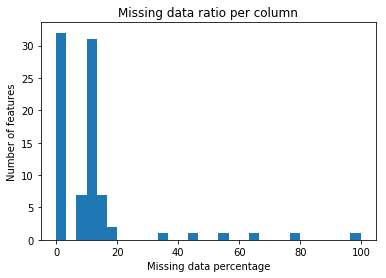

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.figure()
plt.title('Missing data ratio per column')
plt.hist(column_null_proportion['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

It seems that a small number of features have a proportion of missing values greater than 20%. Let's check which are these columns.

In [15]:
column_outliers = column_null_proportion[column_null_proportion['missing_proportion'] > 20]
display(column_outliers)

,features,missing_proportion
0,AGER_TYP,76.955435
11,GEBURTSJAHR,44.020282
40,TITEL_KZ,99.757636
43,ALTER_HH,34.813699
47,KK_KUNDENTYP,65.596749
64,KBA05_BAUMAX,53.468668


We'll remove this columns since we could consider them as *outliers columns*.

In [16]:
# Remove the outlier columns from the dataset. (We'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_no_col_outliers = azdias_nan_replaced.drop(columns=column_outliers.features, axis=1)
print('updated dataframe shape:', azdias_no_col_outliers.shape)

updated dataframe shape: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

After replacing missing labels with appropiate Nan values it could be seen that there where a bunch of columns that are mearly unknow.
The criteria for removing some columns was the checking of the histogram generated. For the proyect seems okay to do that (I'll verify that later hopefully), but I think it requires a more indepth analisis about the features.
The removed columns were (alongside are their missing values percentage): 

|   features   | missing_proportion |
| :----------: | :----------------: |
|   AGER_TYP   |     76.955435      |
| GEBURTSJAHR  |     44.020282      |
|   TITEL_KZ   |     99.757636      |
|   ALTER_HH   |     34.813699      |
| KK_KUNDENTYP |     65.596749      |
| KBA05_BAUMAX |     53.468668      |

#### Step 1.1.3: Assess Missing Data in Each **Row**

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. We'll divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We'll select at least five of these columns and compare the distribution of values.
- We can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, we'll write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. 

In [17]:
# How much data is missing in each row of the dataset?
row_null_proportion = pd.DataFrame(azdias_no_col_outliers.isna().mean(axis=1)*100).reset_index()
row_null_proportion.columns = ['rows_idx', 'missing_proportion']
row_null_proportion = row_null_proportion.sort_values(by=['missing_proportion'], ascending=False)
row_null_proportion.set_index('rows_idx', inplace=True, drop=True)
row_null_proportion.head()

,missing_proportion
rows_idx,
732775,62.025316
643174,62.025316
472919,60.759494
345274,59.493671
299868,59.493671


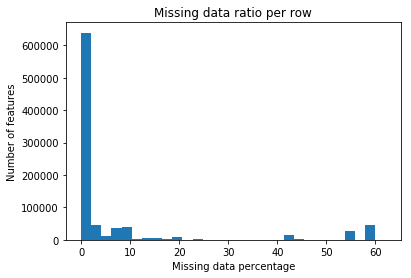

In [18]:
plt.figure()
plt.title('Missing data ratio per row')
plt.hist(row_null_proportion['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

It seems that a small number of rows have a proportion of missing values greater than 30%. Let's check these columns.

In [19]:
# Dividing the data into two subsets based on the number of missing values in each row.
rows_outliers = row_null_proportion[row_null_proportion['missing_proportion'] > 30]
display(rows_outliers.head())

,missing_proportion
rows_idx,
732775,62.025316
643174,62.025316
472919,60.759494
345274,59.493671
299868,59.493671


In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_no_row_outliers = azdias_no_col_outliers.drop(rows_outliers.index, axis=0) 

In [21]:
print('updated dataframe shape:', azdias_no_row_outliers.shape)

updated dataframe shape: (797837, 79)


It is also necesary to handle outliers from each column of the dataset

In [22]:
def mask_outliers(df, prop_threshold):
    """
    Mask the outliers as nans.
    """
    outliers_replaced = []
    df_columns = df.columns.tolist()
    total_records = df.shape[0]
    
    for c in df_columns:
        nulls = df[c].isnull().sum()
        non_nulls = total_records - nulls
        element_proportion_serie = df.groupby(c)[c].count()/non_nulls*100

        element_list = element_proportion_serie.keys().tolist()
        proportion_list = element_proportion_serie.values.tolist()

        # masking values whom proportion is below a threshold
        outlier_elements = [e for e in element_list if element_proportion_serie[e] < prop_threshold]
        for outlier in outlier_elements:
            outliers_replaced.append('outlier: %s, proportion: %s ,column: %s' %(outlier, element_proportion_serie[outlier], c))
            df[c].replace(outlier, np.NaN, inplace = True)

    return df

In [23]:
outlier_threshold = 0.001 # threshold
azdias_clean = mask_outliers(azdias_no_row_outliers, outlier_threshold)

In [24]:
#checking the size of the new dataset without 6 columns
print("number of columns in the final dataset:", azdias_clean.shape[1])
print("number of rows in the original dataset:", df_azdias.shape[0])
print("number of rows in the final dataset:", azdias_clean.shape[0])
print("prop of final dataset with no missing data: {0:.2f}%".format(100*azdias_clean.shape[0]/df_azdias.shape[0]))

number of columns in the final dataset: 79
number of rows in the original dataset: 891221
number of rows in the final dataset: 797837
prop of final dataset with no missing data: 89.52%


#### Discussion 1.1.3: Assess Missing Data in Each Row

The criteria for removing some columns was the checking of the histogram generated. Again, in this scenario it can be seen that the proportion of missing values is above 30 % aprox but I think it requires a more indepth analisis into the business domain to sharp records.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

We will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [25]:
# How many features are there of each data type?
df_feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we'll perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

#### Features comparison between feat_info and azdias dataframes
We could check if all features from feat_info are present in azdias in order to save us time.

In [26]:
feat_info_attribute_list = df_feat_info.attribute.tolist()
azdias_feat_list = azdias_clean.columns.tolist()
f_subset_a = set(feat_info_attribute_list).issubset(azdias_feat_list)
a_subset_f = set(azdias_feat_list).issubset(feat_info_attribute_list)
f_subset_a, a_subset_f

(False, True)

#### Features not present in azdias
Let's check what features are not present in azdias.

In [27]:
feat_not_in_azdias = np.setdiff1d(feat_info_attribute_list, azdias_feat_list).tolist()
print('Features not present in azdias:', feat_not_in_azdias)

Features not present in azdias: ['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


#### Assessing categorical variables
We need to verify which features are `binary`, which are `multi-level`, and which needs to be re-encoded.

In [28]:
# categorical features
categorical_features_list = df_feat_info[df_feat_info["type"]=="categorical"].attribute.tolist()
categorical_features_list_in_df = [x for x in categorical_features_list if x in azdias_clean.columns.tolist()]

In [29]:
# features
categorical_series = azdias_clean[categorical_features_list_in_df].nunique().sort_values()

In [30]:
categorical_count_df = pd.DataFrame(categorical_series).reset_index()
categorical_count_df.columns=['categorical features', 'number of categories']
categorical_count_df

,categorical features,number of categories
0,ANREDE_KZ,2
1,OST_WEST_KZ,2
2,VERS_TYP,2
3,SOHO_KZ,2
4,GREEN_AVANTGARDE,2
5,NATIONALITAET_KZ,3
6,SHOPPER_TYP,4
7,LP_STATUS_GROB,5
8,LP_FAMILIE_GROB,5
9,FINANZTYP,6


We'll get booleans for filtering between binary and non binary categorical features. False values represent the binary ones.

In [31]:
boolean_not_binary_series = categorical_series > 2 
not_binary_features_list = boolean_not_binary_series[boolean_not_binary_series].index.tolist()

In [32]:
print('No binary_features: ', not_binary_features_list)

No binary_features:  ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CJT_GESAMTTYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']


In [33]:
# checking what features are present in azdias
set(not_binary_features_list).issubset(azdias_clean.columns)

True

Re-encoding non binary categorical variables to be kept in the analysis.

In [34]:
azdias_encode = pd.get_dummies(azdias_clean, columns = not_binary_features_list)

In [35]:
# checking that not binary categorical features are not present in azdias after encoding
set(not_binary_features_list).issubset(azdias_encode.columns)

False

Unique binary categorical feature with letters

In [36]:
azdias_encode.OST_WEST_KZ.replace({'O': 0, 'W': 1}, inplace=True)

In [37]:
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

So first it was necesary to identify the categorical features present in the dataset already pre procesed. Then, identify if it was multi or binary categories. For the first type the process is to one hot encode and for the other the only one to be encode was OST_WEST_KZ because it conteined string values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

`Data_Dictionary.md` private file contains the details needed to finish these tasks. I'll detail the process.

In [38]:
print('Features with mixed type: \n')
df_feat_info[df_feat_info['type'] == 'mixed']

Features with mixed type: 



,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Investigating "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [39]:
print('PRAEGENDE_JUGENDJAHRE unique values list: ', azdias_encode['PRAEGENDE_JUGENDJAHRE'].unique().tolist())

PRAEGENDE_JUGENDJAHRE unique values list:  [14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6.0, 4.0, nan, 2.0, 1.0, 12.0, 13.0, 7.0]


In [40]:
# from the docs PRAEGENDE_JUGENDJAHRE  is condensed in two representative variables: decade and movement

def features_from_PRAEGENDE_JUGENDJAHRE(df):
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 'DECADE'] = '40s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 'DECADE'] = '50s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 'DECADE'] = '60s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 'DECADE'] = '70s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 'DECADE'] = '80s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'DECADE'] = '90s'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), 'MOVEMENT'] = 'Mainstream'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,46,7,9,11,13,15]), 'MOVEMENT'] = 'Avantgarde'
    return df

azdias_PRAEGENDE = features_from_PRAEGENDE_JUGENDJAHRE(azdias_encode)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def features_from_CAMEO_INTL_2015(df):
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype(float)

    df.loc[df["CAMEO_INTL_2015"] // 10 == 1.0, 'WEALTH'] = 'Wealthy Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 2.0, 'WEALTH'] = 'Prosperous Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 3.0, 'WEALTH'] = 'Comfortable Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 4.0, 'WEALTH'] = 'Less Affluent Households'
    df.loc[df["CAMEO_INTL_2015"] // 10 == 5.0, 'WEALTH'] = 'Poorer Households'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 1.0, 'LIFE_STAGE'] = 'Pre-Family Couples & Singles'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 2.0, 'LIFE_STAGE'] = 'Young Couples With Children'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 3.0, 'LIFE_STAGE'] = 'Families With School Age Children'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 4.0, 'LIFE_STAGE'] = 'Older Families &  Mature Couples'
    df.loc[df["CAMEO_INTL_2015"] % 10 == 5.0, 'LIFE_STAGE'] = 'Elders In Retirement'
    return df


In [42]:
azdias_mixed = features_from_CAMEO_INTL_2015(azdias_PRAEGENDE)

#### Discussion 1.2.2: Engineer Mixed-Type Features

To engineer this mixed types features it was necesary to analize the .md file with the features detail. These two features have data inside so it was necesary to extract it as part of the azdias dataframe columns. The way i've done it is not very fancy but works.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that the data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

We need to make sure that for any new columns that we have engineered, that we've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, we should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features we created should be retained. As a reminder, our data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# One-hot encode PRAEGENDE_JUGENDJAHRE new features
azdias_mixed_PRAEGENDE_encode = pd.get_dummies(azdias_mixed, columns = ['DECADE', 'MOVEMENT'])
# Drop the original feature
azdias_mixed_PRAEGENDE_encode.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)

In [44]:
# same for CAMEO_INTL_2015 extracted features
azdias_mixed_CAMEO_encode = pd.get_dummies(azdias_mixed_PRAEGENDE_encode, columns = ['WEALTH', 'LIFE_STAGE'])
# Drop the original feature
azdias_mixed_CAMEO_encode.drop('CAMEO_INTL_2015', axis = 1, inplace=True)

In [45]:
azdias_cleaned = azdias_mixed_CAMEO_encode.copy()

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. The function below will be used to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

The helper funciton is saved at `clean_data_helper.py` script.

### Saving the cleaned data
Once cleaned the data will be saved in order to save us time later.

In [46]:
# azdias_cleaned.to_csv('azdias_cleaned.csv')

In [47]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH_Comfortable Households,WEALTH_Less Affluent Households,WEALTH_Poorer Households,WEALTH_Prosperous Households,WEALTH_Wealthy Households,LIFE_STAGE_Elders In Retirement,LIFE_STAGE_Families With School Age Children,LIFE_STAGE_Older Families & Mature Couples,LIFE_STAGE_Pre-Family Couples & Singles,LIFE_STAGE_Young Couples With Children
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,1,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,1,0,0,0,0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,1,0,0


In [48]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Columns: 209 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_Young Couples With Children
dtypes: float64(41), int64(23), uint8(145)
memory usage: 506.0 MB


In [4]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH_Comfortable Households,WEALTH_Less Affluent Households,WEALTH_Poorer Households,WEALTH_Prosperous Households,WEALTH_Wealthy Households,LIFE_STAGE_Elders In Retirement,LIFE_STAGE_Families With School Age Children,LIFE_STAGE_Older Families & Mature Couples,LIFE_STAGE_Pre-Family Couples & Singles,LIFE_STAGE_Young Couples With Children
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,1,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,1,0,0,0,0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,1,0,0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help us navigate to all of the classes and functions that we'll need. In this substep, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# Investigate all nans are removed
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Columns: 209 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_Young Couples With Children
dtypes: float64(41), int64(23), uint8(145)
memory usage: 506.0 MB


In [6]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
imp = Imputer(missing_values=float("NaN"), strategy="mean", axis=1, copy = False)

azdias_cleaned[azdias_cleaned.columns] = scale.fit_transform(imp.fit_transform(azdias_cleaned))

/home/ismael/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH_Comfortable Households,WEALTH_Less Affluent Households,WEALTH_Poorer Households,WEALTH_Prosperous Households,WEALTH_Wealthy Households,LIFE_STAGE_Elders In Retirement,LIFE_STAGE_Families With School Age Children,LIFE_STAGE_Older Families & Mature Couples,LIFE_STAGE_Pre-Family Couples & Singles,LIFE_STAGE_Young Couples With Children
1,-1.512375,0.957932,-1.494575,1.537983,-1.040685,1.466063,0.958965,1.339139,-0.53045,0.107134,...,-0.305667,-0.559009,1.602672,-0.560324,-0.419567,-0.414613,-0.420054,-0.641785,1.501998,-0.327505
2,0.136690,0.957932,-1.494575,0.864621,-1.766949,-0.570955,0.244386,1.339139,1.88519,0.107134,...,-0.305667,-0.559009,-0.623958,1.784682,-0.419567,-0.414613,-0.420054,1.558153,-0.665780,-0.327505
3,0.961223,0.957932,0.683195,-0.482102,1.138107,-0.570955,-1.184772,-0.791524,-0.53045,-0.286092,...,-0.305667,-0.559009,-0.623958,-0.560324,2.383412,-0.414613,-0.420054,-0.641785,-0.665780,3.053388
4,0.136690,-1.043916,0.683195,0.191259,0.411843,-1.249961,0.244386,-0.791524,-0.53045,0.107134,...,-0.305667,1.788880,-0.623958,-0.560324,-0.419567,-0.414613,2.380646,-0.641785,-0.665780,-0.327505
5,-1.512375,0.957932,-0.042728,-1.155464,1.138107,-0.570955,-0.470193,1.339139,-0.53045,0.107134,...,-0.305667,-0.559009,1.602672,-0.560324,-0.419567,-0.414613,-0.420054,1.558153,-0.665780,-0.327505


In [8]:
azdias_cleaned.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH_Comfortable Households,WEALTH_Less Affluent Households,WEALTH_Poorer Households,WEALTH_Prosperous Households,WEALTH_Wealthy Households,LIFE_STAGE_Elders In Retirement,LIFE_STAGE_Families With School Age Children,LIFE_STAGE_Older Families & Mature Couples,LIFE_STAGE_Pre-Family Couples & Singles,LIFE_STAGE_Young Couples With Children
count,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,...,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05
mean,6.428613e-15,-1.588355e-15,-3.205966e-15,3.250555e-16,-1.942080e-14,1.615614e-14,3.600112e-16,-3.439685e-15,-3.501526e-14,-8.170621e-15,...,-1.600662e-14,7.139901e-15,-3.143152e-14,4.656601e-15,5.486927e-15,3.165115e-14,-1.386980e-14,-4.200967e-15,-3.654210e-15,4.505116e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.512375e+00,-1.043916e+00,-1.494575e+00,-1.155464e+00,-1.766949e+00,-1.249961e+00,-1.184772e+00,-1.501745e+00,-5.304505e-01,-6.793171e-01,...,-3.056668e-01,-5.590089e-01,-6.239578e-01,-5.603240e-01,-4.195666e-01,-4.146132e-01,-4.200540e-01,-6.417854e-01,-6.657797e-01,-3.275051e-01
25%,-6.878427e-01,-1.043916e+00,-7.686517e-01,-1.155464e+00,-1.040685e+00,-1.249961e+00,-1.184772e+00,-7.915240e-01,-5.304505e-01,-2.860917e-01,...,-3.056668e-01,-5.590089e-01,-6.239578e-01,-5.603240e-01,-4.195666e-01,-4.146132e-01,-4.200540e-01,-6.417854e-01,-6.657797e-01,-3.275051e-01
50%,1.366901e-01,9.579317e-01,-4.272814e-02,1.912594e-01,4.118430e-01,1.080512e-01,-4.701931e-01,-8.130308e-02,-5.304505e-01,-2.860917e-01,...,-3.056668e-01,-5.590089e-01,-6.239578e-01,-5.603240e-01,-4.195666e-01,-4.146132e-01,-4.200540e-01,-6.417854e-01,-6.657797e-01,-3.275051e-01
75%,9.612228e-01,9.579317e-01,6.831954e-01,8.646211e-01,1.138107e+00,7.870572e-01,9.589645e-01,6.289178e-01,-5.304505e-01,1.071338e-01,...,-3.056668e-01,-5.590089e-01,1.602672e+00,-5.603240e-01,-4.195666e-01,-4.146132e-01,-4.200540e-01,1.558153e+00,1.501998e+00,-3.275051e-01
max,1.536225e+01,9.579317e-01,1.409119e+00,1.537983e+00,1.138107e+00,1.466063e+00,1.673543e+00,1.339139e+00,1.885190e+00,7.791826e+00,...,3.271537e+00,1.788880e+00,1.602672e+00,1.784682e+00,2.383412e+00,2.411887e+00,2.380646e+00,1.558153e+00,1.501998e+00,3.053388e+00


In [9]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Columns: 209 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_Young Couples With Children
dtypes: float64(209)
memory usage: 1.2 GB


### Discussion 2.1: Apply Feature Scaling

Imputer object help me to replace nans. I choose to apply mean for the replacement as it seems to me that it could contribute to a normalized dataset. I also instanciate a standardscalar to scale original columns to mhu 0 and sd to1.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [10]:
# Apply PCA to the data.
pca = PCA()
azdias_default_pca = pca.fit_transform(azdias_cleaned)

In [11]:
# Investigate the variance accounted for by each principal component.
def pca_explained_variance(pca):
    # based on helpers from the nanodegree documents
    explained_variance = pca.explained_variance_ratio_
    explained_variance_accumulated = explained_variance.cumsum()
    x = range(1, len(pca.explained_variance_ratio_) + 1)

    plt.figure(figsize=(16, 8))
    plt.fill_between(x, explained_variance_accumulated, 0, color='#ddeeff')
    plt.bar(x, explained_variance, width=0.5, color='g', label='Variance explained by component')
    plt.plot(x, explained_variance_accumulated, label='Accumulated explained variance')
    plt.grid(True)
    plt.title('Variance explained by PCA components')
    plt.ylabel('Explained variance proportion')
    plt.xlabel('Feature')
    plt.legend()
    plt.show()

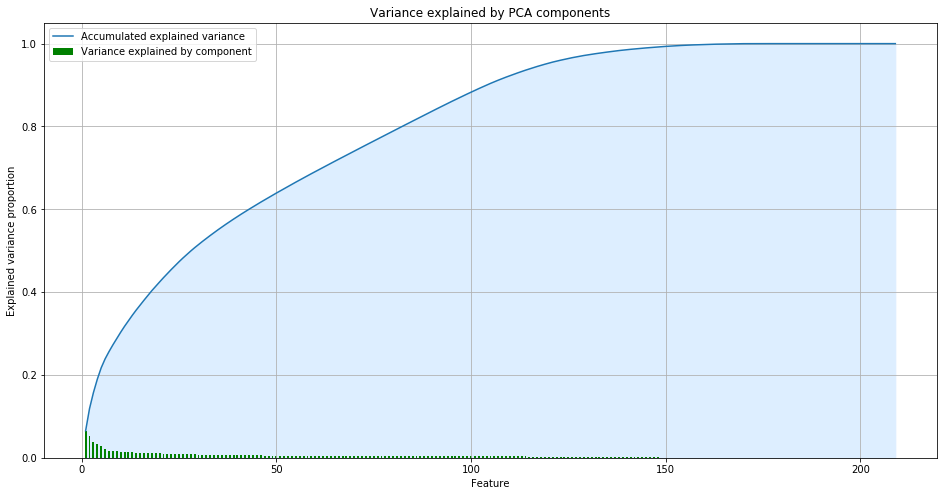

In [12]:
pca_explained_variance(pca)

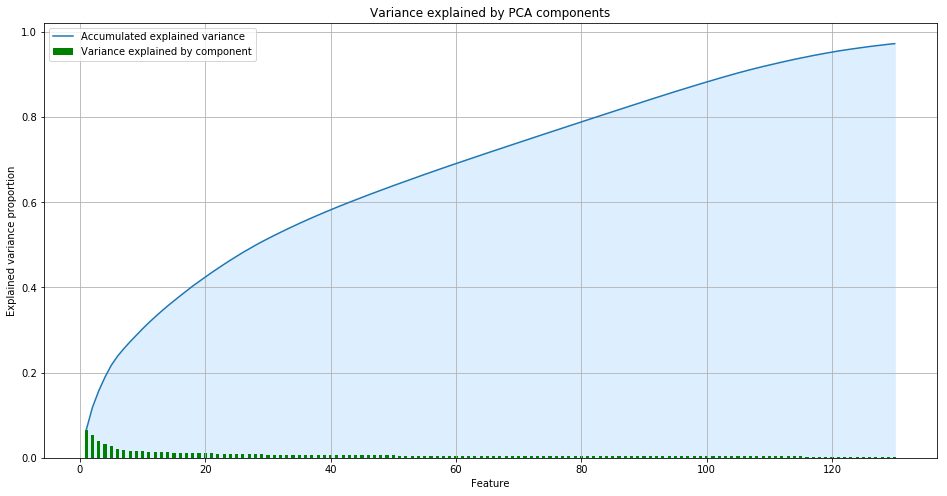

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.
selected_pca = PCA(130)
selected_pca_transform = selected_pca.fit_transform(azdias_cleaned)
pca_explained_variance(selected_pca)

In [14]:
selected_pca.explained_variance_ratio_.sum()

0.9727915558376004

In [17]:
print('selected transformed pca data type:', type(selected_pca_transform)) # numpy array
print('selected transformed pca shape:', selected_pca_transform.shape) # data features per number of components selected: (792287, 130)

selected transformed pca data type: <class 'numpy.ndarray'>
selected transformed pca shape: (797837, 130)


### Discussion 2.2: Perform Dimensionality Reduction

Analizing the first graph it can be seen that around 130 features explain almost 100% data variance so at that point it is reasonable to reduce demensionality.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help we understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [18]:
# Defining a function we can reuse.

def plot_features_proportion_per_pca_component(df, pca, nb_component, component_threshold):
    """
    Plotting X comonent weights over original features.
    """
    df_component = pd.DataFrame(pca.components_, columns=df.columns)
    row = pd.Series(df_component.iloc[nb_component - 1], index=df_component.columns)
    
    # removing components below threshold
    row = row[abs(row) > component_threshold] 
    row = row.sort_values(ascending=False)
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (18,8))
    title = 'Feature proportions for component %s'%(nb_component)
    
    row.plot(ax = ax, kind='bar', title=title)
    plt.xlabel('Features with proportion above %s percent' %component_threshold)
    plt.ylabel('Feature proportion' )
    
    return row

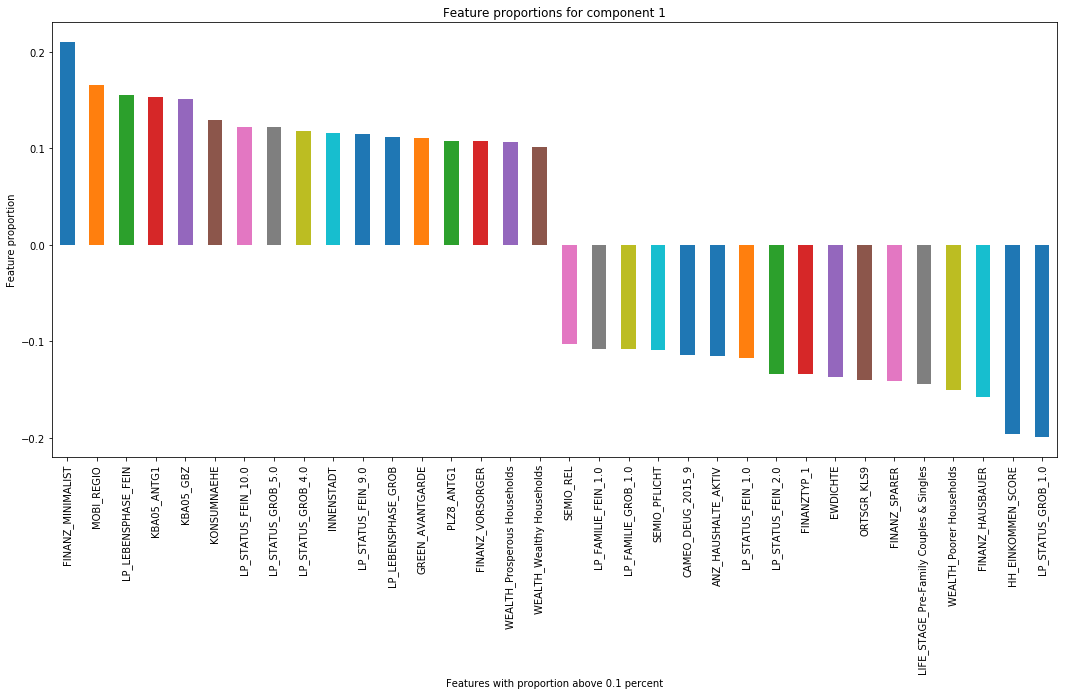

In [19]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_label = 1
feature_proportion_threshold = 0.1
features_proportion_by_PCA_1 = plot_features_proportion_per_pca_component(
                                    azdias_cleaned,
                                    selected_pca, 
                                    feature_label,
                                    feature_proportion_threshold
                                )

In [20]:
features_proportion_by_PCA_1.head()

FINANZ_MINIMALIST      0.210302
MOBI_REGIO             0.165386
LP_LEBENSPHASE_FEIN    0.155614
KBA05_ANTG1            0.152837
KBA05_GBZ              0.151011
Name: 0, dtype: float64

In [21]:
features_proportion_by_PCA_1.tail()

LIFE_STAGE_Pre-Family Couples & Singles   -0.144668
WEALTH_Poorer Households                  -0.150129
FINANZ_HAUSBAUER                          -0.157304
HH_EINKOMMEN_SCORE                        -0.196301
LP_STATUS_GROB_1.0                        -0.199577
Name: 0, dtype: float64

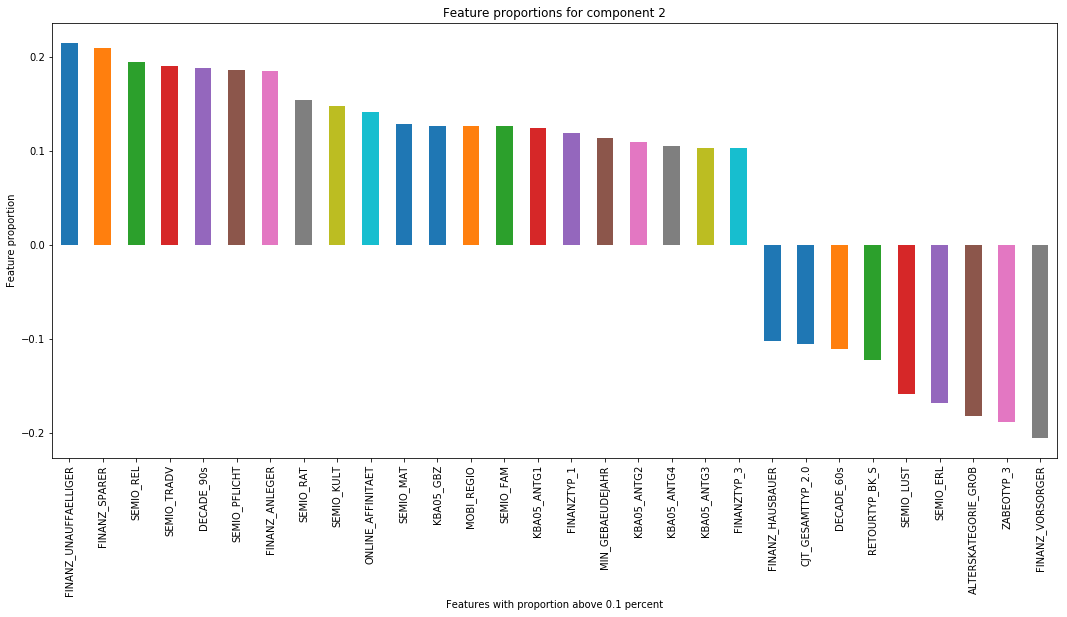

In [22]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_label = 2
feature_proportion_threshold = 0.1
features_proportion_by_PCA_2 = plot_features_proportion_per_pca_component(
                                    azdias_cleaned,
                                    selected_pca, 
                                    feature_label,
                                    feature_proportion_threshold
                                )

In [23]:
features_proportion_by_PCA_2.head()

FINANZ_UNAUFFAELLIGER    0.215025
FINANZ_SPARER            0.209558
SEMIO_REL                0.195113
SEMIO_TRADV              0.190784
DECADE_90s               0.188049
Name: 1, dtype: float64

In [24]:
features_proportion_by_PCA_2.tail()

SEMIO_LUST             -0.158014
SEMIO_ERL              -0.167735
ALTERSKATEGORIE_GROB   -0.181451
ZABEOTYP_3             -0.187946
FINANZ_VORSORGER       -0.205319
Name: 1, dtype: float64

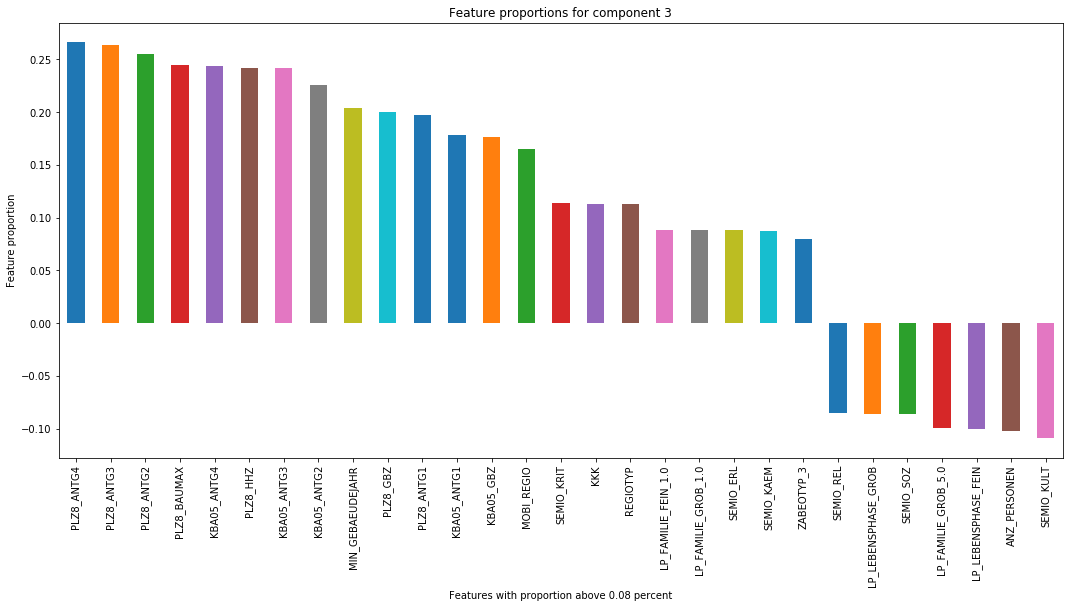

In [25]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_label = 3
feature_proportion_threshold = 0.08
features_proportion_by_PCA_3 = plot_features_proportion_per_pca_component(
                                    azdias_cleaned,
                                    selected_pca, 
                                    feature_label,
                                    feature_proportion_threshold
                                )

In [26]:
features_proportion_by_PCA_3.head()

PLZ8_ANTG4     0.266157
PLZ8_ANTG3     0.263546
PLZ8_ANTG2     0.255079
PLZ8_BAUMAX    0.244720
KBA05_ANTG4    0.243518
Name: 2, dtype: float64

In [27]:
features_proportion_by_PCA_3.tail()

SEMIO_SOZ             -0.086080
LP_FAMILIE_GROB_5.0   -0.099484
LP_LEBENSPHASE_FEIN   -0.100055
ANZ_PERSONEN          -0.101925
SEMIO_KULT            -0.108624
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

The table bellow shows the higher weighted features per component. 
- In the first component it can be seen the relation beetween LP_STATUS_GROB and HH_EINKOMMEN_SCORE	bot related with income earnings. While MOBI_REGIO and FINANZ_MINIMALIST can be also related to income. This component seems to encapsule the **Income feature**.

- The second component is mearly defined by a **finantial feature**.

- The third component seems to be related with a **personality feature** since KBA05_ANTG4 and PLZ8_ANTG4 refer to where the individuos come from or where they were raised. 

|          First component characteristic features         |        Higher Weights associated    |           Description                          |           Feature type      |
|:--------------------------------------------------------:|:-----------------------------------:|:----------------------------------------------:|:---------------------------:|
|        FINANZ_MINIMALIST                                 |   0.2106                            | Financial typology                             |     ordinal                     |
|  MOBI_REGIO                                              | 0.1619                              |  Movement patterns                             | ordinal                     |
|    HH_EINKOMMEN_SCORE                                    | -0.1948                             |  Estimated household net income                | ordinal                   |
| LP_STATUS_GROB_1.0                                       |  -0.1992                            | low-income earners                             |  categorical                 |
| **Second component characteristic features**             | **Higher Weights associated**       | **Description**                                | **Feature type**            |
| FINANZ_UNAUFFAELLIGER                                    | 0.2142                              | Financial typology                             | ordinal                     |
| FINANZ_SPARER                                            | 0.2105                              | Financial typology                             | ordinal                     |
| ZABEOTYP_3                                               | -0.1935                             | Energy consumption typology                    | categorical                 |
| FINANZ_VORSORGER                                         | -0.2067                             | Financial typology                             | ordinal                     |
| **Third component characteristic features**              | **Higher Weights associated**       | **Description**                                | **Feature type**            |
|     PLZ8_ANTG4                                           | 0.2556                              | Number of 10+ family houses in the PLZ8 region | ordinal                     |
| KBA05_ANTG4                                              | 0.2554                              | Number of 10+ family houses in the microcell   | ordinal                     |
| SEMIO_SOZ                                                | -0.1076                             | Personality typology                           | ordinal                     |
| SEMIO_KULT                                               | -0.1219                             | Personality typology                           | ordinal                     |


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. We should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. We have to make sure that we also obtain the cluster assignments for the general demographics data, since we'll be using them in the final Step 3.3.

In [28]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Columns: 209 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_Young Couples With Children
dtypes: float64(209)
memory usage: 1.2 GB


In [31]:
from sklearn.cluster import KMeans
def cluster_scorer(data, nb_cluster):
    # data: pca object
    kmeans_k = KMeans(nb_cluster)
    model = kmeans_k.fit(data)
    return abs(model.score(data))

In [32]:
scores = []
for i in range(1, 16):
    scorer_i = cluster_scorer(selected_pca_transform, i)
    scores.append(scorer_i)
    print('cluster: %s - distance: %s' %(i, scorer_i))

cluster: 1 - distance: 162210981.17577395
cluster: 2 - distance: 154193293.49202096
cluster: 3 - distance: 148869064.6185898
cluster: 4 - distance: 144143872.20668238
cluster: 5 - distance: 141364761.65343997
cluster: 6 - distance: 139305618.8246575
cluster: 7 - distance: 136936169.64040667
cluster: 8 - distance: 135472114.91433242
cluster: 9 - distance: 134132027.95573781
cluster: 10 - distance: 133129333.25475404
cluster: 11 - distance: 131819362.29874377
cluster: 12 - distance: 131346934.84852096
cluster: 13 - distance: 130254994.95624195
cluster: 14 - distance: 128886752.97294386
cluster: 15 - distance: 127595434.58765525


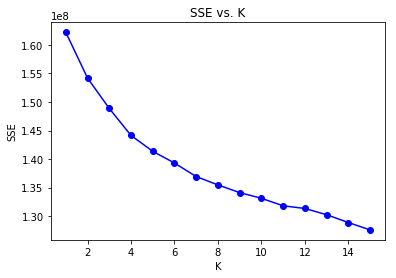

In [33]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(np.linspace(1,15,15), scores, linestyle='-', marker='o', color='blue')

In [34]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=11)
km_model = kmeans.fit(selected_pca_transform)
azdias_predicted_labels = km_model.predict(selected_pca_transform)

In [35]:
kmeans_centers = kmeans.cluster_centers_

### Discussion 3.1: Apply Clustering to General Population

After analizing the result graphic it seems appropiate to choose a number of 11 clusters since it seems to be a elbow from where the distance beetween points and the center doesnt decrese much after when adding more clusters (Note for me: It took a really long time to perform calculations on all those clusters).

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [71]:
# checking the proportion of NaNs per feature in the dataframe
column_null_proportion_cust = pd.DataFrame(customers.isna().mean(axis=0)*100).reset_index()
column_null_proportion_cust.columns = ['features', 'missing_proportion']
display(column_null_proportion_cust[column_null_proportion_cust['missing_proportion']>20].head())

,features,missing_proportion
39,SOHO_KZ,24.312817
40,TITEL_KZ,24.312817
43,ALTER_HH,24.312817
44,ANZ_PERSONEN,24.312817
45,ANZ_TITEL,24.312817


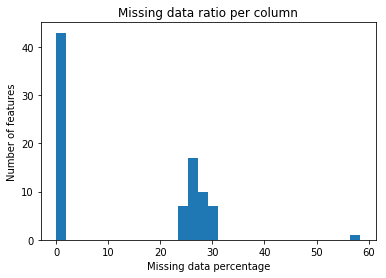

In [72]:
plt.figure()
plt.title('Missing data ratio per column')
plt.hist(column_null_proportion_cust['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

Given the plot above seem reasonable to drop columns with missing values above 35%, otherwise a lot of valuable data will be lost.

In [73]:
# checking the proportion of NaNs per feature in the dataframe
row_null_proportion_cust = pd.DataFrame(customers.isna().mean(axis=1)*100).reset_index()
row_null_proportion_cust.columns = ['features', 'missing_proportion']
display(row_null_proportion_cust[row_null_proportion_cust['missing_proportion']>20].head())

,features,missing_proportion
1,1,52.941176
10,10,40.000000
36,36,49.411765
37,37,49.411765
38,38,49.411765


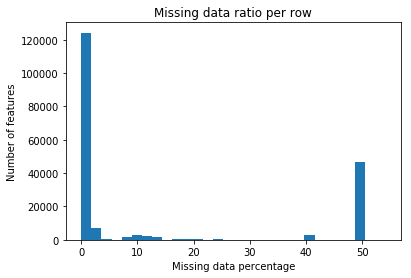

In [74]:
plt.figure()
plt.title('Missing data ratio per row')
plt.hist(row_null_proportion_cust['missing_proportion'], bins = 30)
plt.xlabel('Missing data percentage')
plt.ylabel('Number of features')
plt.show()

It seems that there's a lot of missing values for a large amount of rows. It will be descarted as well since it's likely to mess the model.

In [78]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
from clean_data_helper import clean_data

row_proportion_thresh=30
col_proportion_thresh=35
outlier_threshold =0.001 # threshold percentage
customer_df_cleaned = clean_data(customers, row_proportion_thresh, col_proportion_thresh, outlier_threshold)

outlier columns removed: 
AGER_TYP        50.475863
GEBURTSJAHR     48.537975
TITEL_KZ        98.793647
ALTER_HH        35.870745
KK_KUNDENTYP    58.406382
KBA05_BAUMAX    57.153069
dtype: float64


In [79]:
print('customers dataframe cleaned shape:', customer_df_cleaned.shape)

customers dataframe cleaned shape: (141690, 209)


In [80]:
len(scale.mean_) # it should be the same number of columns to perform the transform on scale

209

In [82]:
cols_c = customer_df_cleaned.columns.tolist()
cols_p = azdias_cleaned.columns.tolist()

In [83]:
feat_in_cust_not_in_pop= np.setdiff1d(cols_c,cols_p).tolist()
print(feat_in_cust_not_in_pop)

[]


In [84]:
# scaling, removing nans and predicting
customer_df_cleaned[customer_df_cleaned.columns] = scale.transform(imp.transform(customer_df_cleaned))

In [85]:
# pca
customers_pca = selected_pca.transform(customer_df_cleaned)
customers_azdias_predicted_labels = km_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [86]:
# plotting function definition
def compare_clusters(clust_a, clust_b, label_clust_a, label_clust_b):
    # proportions by value
    series_a = pd.Series(clust_a)
    series_b = pd.Series(clust_b)
    values_count_a = series_a.value_counts()
    values_count_b = series_b.value_counts()
    values_prop_a = values_count_a.sort_index() / values_count_a.sum()
    values_prop_b = values_count_b.sort_index() / values_count_b.sum()

    # merge columns
    df = pd.merge(values_prop_a.reset_index(), values_prop_b.reset_index(), 
                    on='index', how='outer').fillna(0)

    # reshape dataframe
    df.columns = ['index', label_clust_a, label_clust_b]
    df = df.set_index('index').stack().reset_index()
    df.columns = ['Cluster Index', 'Dataset', 'Proportion']
    df = df.fillna(0)
    
    # plot comparison
    plt.figure(figsize=(16, 6))
    g = sns.barplot(data=df, x='Cluster Index', y='Proportion', hue='Dataset')
    g.set_title('Cluster comparison proportion between population and customer')

    plt.show()
    
    return df

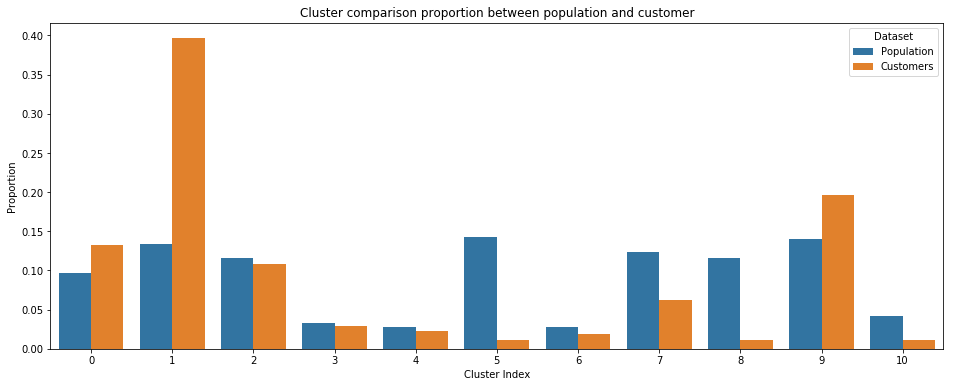

In [87]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_comparison = compare_clusters(azdias_predicted_labels, 
                                 customers_azdias_predicted_labels, 
                                 'Population', 
                                 'Customers'
                )

Cluster 2, 3, 4 and 6 in the plot above seem to have a matching beetween general population and customers so those can be a target audience for the company.

There is a higher proportion of people in cluster 0, 1 and 9 for the customer data compared to the general population, this suggests people in that cluster to be a target audience for the company.

The proportion of the data in remaining clusters being larger in the general population than the customer data that group of persons to be outside of the target demographics.

In [96]:
# get center in original space
centers = selected_pca.inverse_transform(kmeans_centers)
centers = scale.inverse_transform(centers)

In [89]:
# Display the true centers calculated from population dataset
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
pop_centers = pd.DataFrame(np.round(centers, 4), columns = azdias_cleaned.columns)
pop_centers.index = segments

From section 2.3 we had the following relevant positive correlated features per principal components:
- **Component 1**: 'FINANZ_MINIMALIST', 'MOBI_REGIO', 'LP_LEBENSPHASE_FEIN', 'KBA05_ANTG1', 'KBA05_GBZ' : **income**
    
- **Component 2**: 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_TRADV', 'DECADE_90s' : **finance**

- **Component 3**: 'PLZ8_ANTG4','KBA05_ANTG4','KBA05_ANTG3','PLZ8_ANTG3','PLZ8_ANTG2' : **personality**

In [91]:
# analizing strongly correlated weighted features

comp1_high_relevant_features = ['FINANZ_MINIMALIST', 'MOBI_REGIO', 'LP_LEBENSPHASE_FEIN', 'KBA05_ANTG1', 'KBA05_GBZ']          
comp2_high_relevant_features = ['FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_TRADV', 'DECADE_90s']          
comp3_high_relevant_features = ['PLZ8_ANTG4','KBA05_ANTG4','KBA05_ANTG3','PLZ8_ANTG3','PLZ8_ANTG2']

relevant_features = comp1_high_relevant_features + comp2_high_relevant_features + comp3_high_relevant_features

In [92]:
# overrated clusters
overrated_segments = ['Segment 2']

# underrated clusters
underrated_segments = ['Segment 4']

relevant_segments = overrated_segments + underrated_segments

In [93]:
def display_deviation_from_mean_and_variance_per_df(centers, segments, df, df_label, features):
    
    segment_centers = centers.loc[segments,]
    # analizing median since its less propense to noise
    print('True population centers offset from %s MEDIAN for relevant segments'%(df_label.upper(), ))
    segment_centers_median_deviation= segment_centers - np.round(scale.inverse_transform((df).median()))
    display(segment_centers_median_deviation[features])

In [94]:
# over and under represented cluster: population
display_deviation_from_mean_and_variance_per_df(
    pop_centers, relevant_segments, azdias_cleaned, 'population', relevant_features
)

True population centers offset from POPULATION MEDIAN for relevant segments


,FINANZ_MINIMALIST,MOBI_REGIO,LP_LEBENSPHASE_FEIN,KBA05_ANTG1,KBA05_GBZ,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,SEMIO_REL,SEMIO_TRADV,DECADE_90s,PLZ8_ANTG4,KBA05_ANTG4,KBA05_ANTG3,PLZ8_ANTG3,PLZ8_ANTG2
Segment 2,0.1261,0.0422,0.0578,0.5074,0.2084,-0.3041,-1.4259,-2.0491,-1.6285,0.0243,-0.4479,0.2437,0.7144,-0.5431,-0.2434
Segment 4,-0.3852,-0.6966,-0.7487,-0.1191,-0.3367,0.7439,-0.1335,0.1305,-0.1401,0.3118,0.1151,0.5097,0.8886,0.1564,0.2094


In [95]:
# over and underrepresented cluster: customers
display_deviation_from_mean_and_variance_per_df(
    pop_centers, relevant_segments, customer_df_cleaned, 'customers', relevant_features
)

True population centers offset from CUSTOMERS MEDIAN for relevant segments


,FINANZ_MINIMALIST,MOBI_REGIO,LP_LEBENSPHASE_FEIN,KBA05_ANTG1,KBA05_GBZ,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,SEMIO_REL,SEMIO_TRADV,DECADE_90s,PLZ8_ANTG4,KBA05_ANTG4,KBA05_ANTG3,PLZ8_ANTG3,PLZ8_ANTG2
Segment 2,-1.8739,-0.9578,-6.9422,-0.4926,-0.7916,-0.3041,0.5741,-1.0491,-0.6285,0.0243,0.5521,0.2437,0.7144,0.4569,-0.2434
Segment 4,-2.3852,-1.6966,-7.7487,-1.1191,-1.3367,0.7439,1.8665,1.1305,0.8599,0.3118,1.1151,0.5097,0.8886,1.1564,0.2094


### Analizing clusters relation beetween population and customers:

First thing to check is that the distance from records to cluster centers are similar. This is true for most of the features in both population and customer dataset which means that the clusters describe well enough customers patterns. It gets easy to visualize per segment and component:

* **Overrated cluster: Segment 2**

| component number | segments (clusters)  | FINANZ_MINIMALIST | MOBI_REGIO | LP_LEBENSPHASE_FEIN | KBA05_ANTG1 | KBA05_GBZ |
|------------------|----------------------|-------------------|------------|---------------------|-------------|-----------|
| 1                | Segment 2 population | -1.9346           | -2.7252    | -12.1915            | -0.7515     | -2.8152   |
| 1                | Segment 2 customers  | -3.9346           | -3.7252    | -19.1915            | -1.7515     | -3.8152   |
| 2                | Segment 2 population | -2.2354           | -3.5600    | -4.3658             | -4.2350     | -0.3606   |
| 2                | Segment 2 customers  | -2.2354           | -1.5600    | -3.3658             | -3.2350     | -0.3606   |
| 3                | Segment 2 population | -1.3107           | -0.3031    | -0.3898             | -2.3604     | -3.2807   |
| 3                | Segment 2 customers  | -0.3107           | -0.3031    | -0.3898             | -1.3604     | -3.2807   |



* **Under rated clusters: Segment 4** 

| component number | segments (clusters)  | FINANZ_MINIMALIST | MOBI_REGIO | LP_LEBENSPHASE_FEIN | KBA05_ANTG1 | KBA05_GBZ |
|------------------|----------------------|-------------------|------------|---------------------|-------------|-----------|
| 1                | Segment 4 population | -4.2467           | -3.5759    | -13.5778            | -1.5177     | -3.5121   |
| 1                | Segment 4 customers  | -6.2467           | -4.5759    | -20.5778            | -2.5177     | -4.5121   |
| 2                | Segment 4 population | -1.1386           | -1.7925    | -3.1583             | -2.9965     | 1.1073    |
| 2                | Segment 4 customers  | -1.1386           | 0.2075     | -2.1583             | -1.9965     | 1.1073    |
| 3                | Segment 4 population | -0.8940           | -0.1174    | -0.0540             | -1.7910     | -2.9013   |
| 3                | Segment 4 customers  | 0.1060            | -0.1174    | -0.0540             | -0.7910     | -2.9013   |


### Identifying customer segments in relevant clusters

* **Overrated cluster: Segment 2**

It can be seen that features from component 1 are the features that represent the second cluster with highest values over the other features. The type of customers in this cluster are the ones whom can be identify as **finantialy stable**, have **reduce family elements**.

|  FINANZ_MINIMALIST |        MOBI_REGIO | LP_LEBENSPHASE_FEIN |                                  KBA05_ANTG1 |
| -----------------: | ----------------: | ------------------: | -------------------------------------------: |
| Financial typology | Movement patterns |          Life stage | Number of 1-2 family houses in the microcell |


* **Under rated clusters: Segment 4**

It can be seen that features from component 3 are the features that represent the second cluster with highest values over the other features. It also can be seen that DECADE_90s fits in this group as well. This cluster clearly identifies people whit **higher number of family members** and segregated by **region**. 

|                   PLZ8_ANTG4                   |                 KBA05_ANTG4                  |                  KBA05_ANTG3                  |                   PLZ8_ANTG3                    |
| :--------------------------------------------: | :------------------------------------------: | :-------------------------------------------: | :---------------------------------------------: |
| Number of 10+ family houses in the PLZ8 region | Number of 10+ family houses in the microcell | Number of 6-10 family houses in the microcell | Number of 6-10 family houses in the PLZ8 region |


### Discussion 3.3: Compare Customer Data to Demographics Data

After analyzing the plot results about the clusters per origin_data_frame (population, customers) and the corresponding features associated with the principal components it can be seen that there is a valuable insight this analysis that can be used to select the appropriate target population after identifying customer segments.
So in conclution, the target population should be in the active middle class, related with economical status (not sure if that is the correct way to say it but what I'm trying to mean is that one of the target population is the one that has money, in the middle-class range).